## ARIMA Modeling (an attempt)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ts_func
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
df = pd.read_csv('air_quality_weather_fires.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['site_id', 'date'])

In [8]:
df.head()

,Unnamed: 0,date,site_id,latitude,longitude,state_name,county_name,city_name,site_name,PM25,...,has_nearby_fire,datetime,month,day_of_week,is_weekend,season,wildfire_season,fire_distance_category,fire_intensity,humidity_category
0,0,2024-01-01,01-073-0023,33.553056,-86.815,Alabama,Jefferson,Birmingham,North Birmingham,11.55,...,1,2024-01-01,1,0,0,winter,0,close,low,Low Humidity
61,61,2024-01-02,01-073-0023,33.553056,-86.815,Alabama,Jefferson,Birmingham,North Birmingham,10.35,...,1,2024-01-02,1,1,0,winter,0,close,low,Low Humidity
118,118,2024-01-03,01-073-0023,33.553056,-86.815,Alabama,Jefferson,Birmingham,North Birmingham,23.25,...,1,2024-01-03,1,2,0,winter,0,very_close,low,High Humidity
174,174,2024-01-04,01-073-0023,33.553056,-86.815,Alabama,Jefferson,Birmingham,North Birmingham,19.40,...,1,2024-01-04,1,3,0,winter,0,very_close,low,High Humidity
235,235,2024-01-05,01-073-0023,33.553056,-86.815,Alabama,Jefferson,Birmingham,North Birmingham,14.65,...,1,2024-01-05,1,4,0,winter,0,very_close,low,Low Humidity


## Conditional ARIMA Modeling

An attempt to ompare recovery patterns by:
1. Distance from fire (close vs far)
2. Humidity levels
3. Combined conditions

In [12]:
df = df[df['has_nearby_fire'] == 1]

# Re-map labels to fire distance categories
label_map = {'very_close': 'Very Close (0-25km)',
             'close': 'Close (25-50km)',
             'moderate': 'Moderate (50-100km)',
             'far': 'Far (100km+)'}
df.replace({"fire_distance_category": label_map}, inplace=True)

# Create humidity categories
humidity_median = df['relative_humidity_2m_mean'].median()
df['humidity_category'] = pd.cut(
    df['relative_humidity_2m_mean'],
    bins=[0, humidity_median, 100],
    labels=['Low Humidity', 'High Humidity']
)

print(f"\nDistance categories:")
print(df['fire_distance_category'].value_counts())
print(f"\nHumidity categories (median split at {humidity_median:.1f}%):")
print(df['humidity_category'].value_counts())


Distance categories:
fire_distance_category
Far (100km+)           8558
Very Close (0-25km)    4077
Moderate (50-100km)    3827
Close (25-50km)        3291
Name: count, dtype: int64

Humidity categories (median split at 68.0%):
humidity_category
Low Humidity     9951
High Humidity    9802
Name: count, dtype: int64


In [14]:
# Create aggregated PM2.5 time series for each condition

# by distance categories:
ts_very_close = df[df['fire_distance_category'] == 'Very Close (0-25km)'].groupby('date')['PM25'].mean()
ts_close = df[df['fire_distance_category'] == 'Close (25-50km)'].groupby('date')['PM25'].mean()
ts_moderate = df[df['fire_distance_category'] == 'Close (25-50km)'].groupby('date')['PM25'].mean()

# by humidity categories:
ts_low_humidity = df[df['humidity_category'] == 'Low Humidity'].groupby('date')['PM25'].mean()
ts_high_humidity = df[df['humidity_category'] == 'High Humidity'].groupby('date')['PM25'].mean()

# Combined conditions (4 groups)
ts_close_dry = df[
    (df['distance_to_fire_km'] <= 50) & 
    (df['humidity_category'] == 'Low Humidity')
].groupby('date')['PM25'].mean()

ts_close_humid = df[
    (df['distance_to_fire_km'] <= 50) & 
    (df['humidity_category'] == 'High Humidity')
].groupby('date')['PM25'].mean()

ts_far_dry = df[
    (df['distance_to_fire_km'] > 50) & 
    (df['humidity_category'] == 'Low Humidity')
].groupby('date')['PM25'].mean()

ts_far_humid = df[
    (df['distance_to_fire_km'] > 50) & 
    (df['humidity_category'] == 'High Humidity')
].groupby('date')['PM25'].mean()

In [21]:
ts_func.check_stationarity(ts_very_close, "Very Close Fires (<25km)")
ts_func.check_stationarity(ts_close, "Close Fires (25-50km)")
ts_func.check_stationarity(ts_moderate, "Moderate Distance Fires (50-100km)")
ts_func.check_stationarity(ts_low_humidity, "Low Humidity")
ts_func.check_stationarity(ts_high_humidity, "High Humidity")


Very Close Fires (<25km):
  ADF Statistic: -4.5684
  P-value: 0.0001
  → Stationary

Close Fires (25-50km):
  ADF Statistic: -12.4981
  P-value: 0.0000
  → Stationary

Moderate Distance Fires (50-100km):
  ADF Statistic: -12.4981
  P-value: 0.0000
  → Stationary

Low Humidity:
  ADF Statistic: -3.6942
  P-value: 0.0042
  → Stationary

High Humidity:
  ADF Statistic: -7.6157
  P-value: 0.0000
  → Stationary


True

In [ ]:
results_low_humidity, best_order_low_humidity = ts_func.grid_search_arima(ts_low_humidity, "Low Humidity", max_p = 3, max_d = 2, max_q = 3)
# Determined that ARIMA(0,1,3) results in lowest AIC & RMSE -- but ARIMA(1,1,1) results in very similar AIC & RMSE

In [ ]:
results_high_humidity, best_order_high_humidity = ts_func.grid_search_arima(ts_high_humidity, "High Humidity", max_p = 3, max_d = 2, max_q = 3)
# Determined that ARIMA(3,0,2) results in lowest AIC & RMSE -- but ARIMA(1,1,1) results in very similar AIC & RMSE

In [ ]:
if best_order_low_humidity is not None:
    fitted_low, resid_low = ts_func.diagnose_arima(ts_low_humidity, best_order_low_humidity, "Low Humidity")
else:
    fitted_low, resid_low = None, None
# meet all assumptions besides normality test

if best_order_high_humidity is not None:
    fitted_high, resid_high = ts_func.diagnose_arima(ts_high_humidity, best_order_high_humidity, "High Humidity")
else:
    fitted_high, resid_high = None, None
# meet all assumptions besides normality test

In [ ]:
model_low_humidity = ts_func.fit_arima_model(ts_low_humidity, "Low Humidity", order = (1,1,1))
model_high_humidity = ts_func.fit_arima_model(ts_high_humidity, "High Humidity", order = (1,1,1))
# easier to interpret than the "best order" models
# d = 1 represents that series needs differencing (although ADF did determine that these were stationary processes despite PM2.5, when not grouped by humidity levels, being non-stationary)
# AR(1) demonstrates yesterday's PM2.5 affects today
# MA(1) represents yesterday's shock/error affects today


Low Humidity:
  Data points: 365
  Mean PM2.5: 7.36
  Std PM2.5: 2.28


c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

  ARIMA(1, 1, 1) AIC: 1437.42
  AR coefficient(s): [0.49121736]
  MA coefficient(s): [-0.93110534]
  Half-life: 0.98 days

High Humidity:
  Data points: 365
  Mean PM2.5: 7.62
  Std PM2.5: 2.27


c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  ARIMA(1, 1, 1) AIC: 1347.47
  AR coefficient(s): [0.72812157]
  MA coefficient(s): [-0.98459635]
  Half-life: 2.18 days


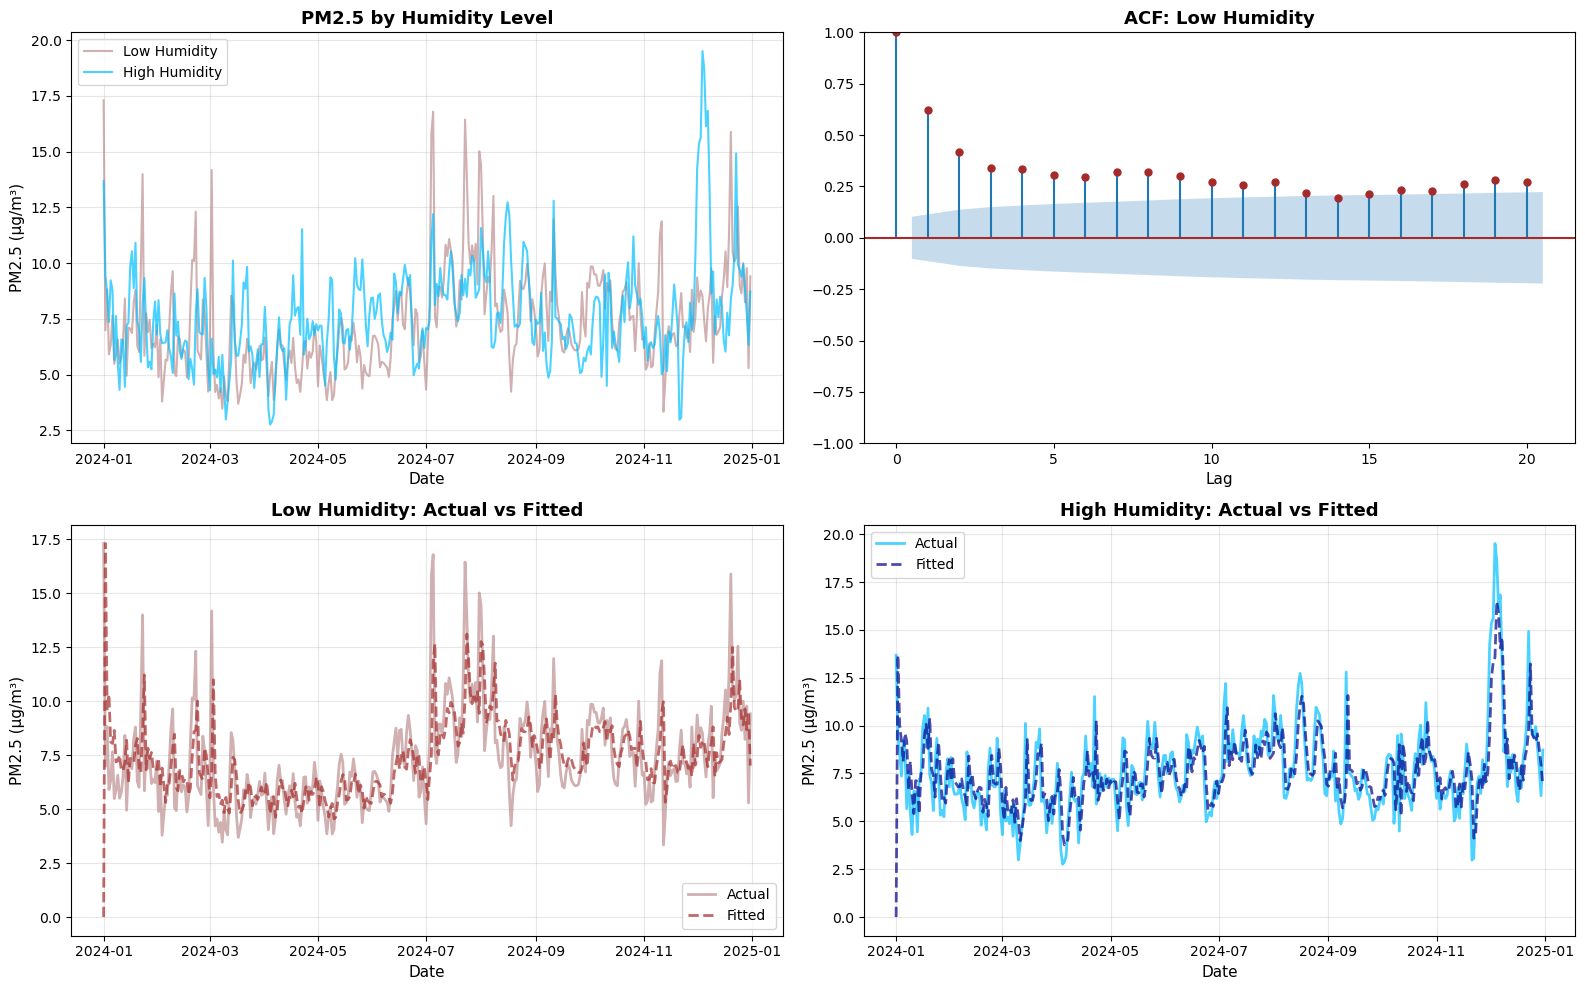

In [87]:
# Plotting low vs. high humidity ARIMA models
# Used ARIMA(1,1,1) models since the higher complexity model was not as interpretable

fig, axes = plt.subplots(2, 2, figsize = (16, 10))
ax1 = axes[0, 0]
ax1.plot(ts_low_humidity.index, ts_low_humidity.values, 
         linewidth=1.5, alpha=0.7, label='Low Humidity', color='rosybrown')
ax1.plot(ts_high_humidity.index, ts_high_humidity.values, 
         linewidth=1.5, alpha=0.7, label='High Humidity', color='deepskyblue')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax1.set_title('PM2.5 by Humidity Level', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: ACF comparison - Low Humidity
ax2 = axes[0, 1]
if len(ts_low_humidity.dropna()) >= 30:
    plot_acf(ts_low_humidity.dropna(), lags=20, ax=ax2, alpha=0.05, 
             color='brown')
ax2.set_title('ACF: Low Humidity', fontsize=13, fontweight='bold')
ax2.set_xlabel('Lag', fontsize=11)

# Plot 3: Fitted values vs actual (Low Humidity)
ax3 = axes[1, 0]
ax3.plot(model_low_humidity.fittedvalues.index, ts_low_humidity[model_low_humidity.fittedvalues.index], 
            linewidth=2, alpha=0.7, label='Actual', color='rosybrown')
ax3.plot(model_low_humidity.fittedvalues.index, model_low_humidity.fittedvalues, 
            linewidth=2, alpha=0.7, label='Fitted', linestyle='--', color='brown')
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax3.set_title('Low Humidity: Actual vs Fitted', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Fitted values vs actual (High Humidity)
ax4 = axes[1, 1]
ax4.plot(model_high_humidity.fittedvalues.index, ts_high_humidity[model_high_humidity.fittedvalues.index], 
            linewidth=2, alpha=0.7, label='Actual', color='deepskyblue')
ax4.plot(model_high_humidity.fittedvalues.index, model_high_humidity.fittedvalues, 
            linewidth=2, alpha=0.7, label='Fitted', linestyle='--', color='darkblue')
ax4.set_xlabel('Date', fontsize=11)
ax4.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax4.set_title('High Humidity: Actual vs Fitted', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()

In [ ]:
results_close_dry, best_order_close_dry = ts_func.grid_search_arima(ts_close_dry, "Close + Dry", max_p = 3, max_d = 2, max_q = 3)
# Determined that ARIMA(0,1,3) results in lowest AIC & RMSE -- but ARIMA(1,1,1) results 2nd best AIC & RMSE


Close + Dry
------------------------------------------------------------
Testing 47 model combinations...


c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin


Successfully fitted 47 models

Top 10 models by AIC:
    order         aic         bic     rmse
(3, 1, 3) 1357.843438 1383.435380 3.125413
(1, 1, 1) 1358.504084 1369.472059 3.130986
(3, 1, 1) 1358.995632 1377.275591 3.136234
(0, 1, 3) 1359.139296 1373.763263 3.130559
(2, 1, 3) 1359.184652 1381.120603 3.138535
(3, 1, 2) 1359.733392 1381.669343 3.134085
(2, 1, 1) 1360.342303 1374.966270 3.132900
(1, 1, 2) 1360.405180 1375.029147 3.132122
(1, 1, 3) 1361.104485 1379.384444 3.129733
(0, 1, 2) 1361.322356 1372.290331 3.144073

✓ Best model: ARIMA(3, 1, 3)
  AIC: 1357.84
  BIC: 1383.44
  Out-of-sample RMSE: 3.13


c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
results_close_humid, best_order_close_humid = ts_func.grid_search_arima(ts_close_humid, "Close + Humid", max_p = 3, max_d = 2, max_q = 3)
# Best model determined to be ARIMA(1,1,1)


Close + Humid
------------------------------------------------------------
Testing 47 model combinations...


c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin


Successfully fitted 47 models

Top 10 models by AIC:
    order         aic         bic     rmse
(1, 1, 1) 1321.893019 1332.860994 5.549503
(1, 1, 2) 1322.720159 1337.344127 5.560452
(3, 1, 1) 1322.777830 1341.057789 5.569318
(1, 0, 1) 1322.952989 1337.590918 5.664645
(3, 0, 0) 1322.981916 1341.279327 5.669656
(0, 1, 2) 1323.166673 1334.134648 5.549541
(2, 1, 1) 1323.520736 1338.144703 5.550993
(1, 0, 2) 1323.985083 1342.282494 5.662306
(1, 0, 0) 1324.092234 1335.070681 5.661310
(2, 0, 1) 1324.259688 1342.557100 5.662579

✓ Best model: ARIMA(1, 1, 1)
  AIC: 1321.89
  BIC: 1332.86
  Out-of-sample RMSE: 5.55


c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\annaj\miniconda3\envs\ds6001\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [64]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [84]:
# Time Series with Fitted Values
# Create subplots
fig_forecast = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Low Humidity - ARIMA(1,1,1)', 'High Humidity - ARIMA(1,1,1)'),
    vertical_spacing=0.12
)

# Low Humidity
fig_forecast.add_trace(
    go.Scatter(
        x=ts_low_humidity.index,
        y=ts_low_humidity.values,
        mode='lines',
        name='Actual (Low)',
        line=dict(color='#3498db', width=2),
        hovertemplate='<b>Date</b>: %{x|%Y-%m-%d}<br><b>PM2.5</b>: %{y:.2f} μg/m³<extra></extra>'
    ),
    row=1, col=1
)

fig_forecast.add_trace(
    go.Scatter(
        x=model_low_humidity.fittedvalues.index,
        y=model_low_humidity.fittedvalues.values,
        mode='lines',
        name='Fitted (Low)',
        line=dict(color='#2ecc71', width=2, dash='dash'),
        hovertemplate='<b>Date</b>: %{x|%Y-%m-%d}<br><b>Fitted</b>: %{y:.2f} μg/m³<extra></extra>'
    ),
    row=1, col=1
)


# High Humidity
fig_forecast.add_trace(
    go.Scatter(
        x=ts_high_humidity.index,
        y=ts_high_humidity.values,
        mode='lines',
        name='Actual (High)',
        line=dict(color='#9b59b6', width=2),
        hovertemplate='<b>Date</b>: %{x|%Y-%m-%d}<br><b>PM2.5</b>: %{y:.2f} μg/m³<extra></extra>'
    ),
    row=2, col=1
)

fig_forecast.add_trace(
    go.Scatter(
        x=model_high_humidity.fittedvalues.index,
        y=model_high_humidity.fittedvalues.values,
        mode='lines',
        name='Fitted (High)',
        line=dict(color='#1abc9c', width=2, dash='dash'),
        hovertemplate='<b>Date</b>: %{x|%Y-%m-%d}<br><b>Fitted</b>: %{y:.2f} μg/m³<extra></extra>'
    ),
    row=2, col=1
)


fig_forecast.update_xaxes(title_text="Date", row=2, col=1)
fig_forecast.update_yaxes(title_text="PM2.5 (μg/m³)", row=1, col=1)
fig_forecast.update_yaxes(title_text="PM2.5 (μg/m³)", row=2, col=1)

fig_forecast.update_layout(
    title_text='<b>PM2.5 Time Series: Historical & Fitted</b>',
    title_x=0.5,
    height=800,
    hovermode='x unified',
    font=dict(size=12)
)

In [86]:
# Find days with significant PM2.5 increases (shocks)
def identify_shocks(ts, threshold_percentile=90):
    """Identify days with large PM2.5 increases"""
    changes = ts.diff()
    shock_threshold = changes.quantile(threshold_percentile / 100)
    shock_days = changes[changes > shock_threshold].index
    return shock_days

shock_days_low = identify_shocks(ts_low_humidity)
shock_days_high = identify_shocks(ts_high_humidity)

print(f"Identified {len(shock_days_low)} shock events (low humidity)")
print(f"Identified {len(shock_days_high)} shock events (high humidity)")

# Create event study window
window_before = 3
window_after = 14

def event_study(ts, shock_days, window_before, window_after):
    """Calculate average response around shock events"""
    events = []
    
    for shock_day in shock_days:
        try:
            shock_idx = ts.index.get_loc(shock_day)
            if shock_idx >= window_before and shock_idx + window_after < len(ts):
                # Get window around event
                window = ts.iloc[shock_idx - window_before : shock_idx + window_after + 1]
                # Normalize to shock day = 0
                window_normalized = window.values - window.iloc[window_before]
                events.append(window_normalized)
        except:
            continue
    
    if len(events) == 0:
        return None
    
    # Average across events
    events_array = np.array(events)
    avg_response = np.mean(events_array, axis=0)
    std_response = np.std(events_array, axis=0)
    
    return avg_response, std_response, events_array

result_low = event_study(ts_low_humidity, shock_days_low, window_before, window_after)
result_high = event_study(ts_high_humidity, shock_days_high, window_before, window_after)

if result_low and result_high:
    avg_low, std_low, events_low = result_low
    avg_high, std_high, events_high = result_high
    
    days_relative = np.arange(-window_before, window_after + 1)
    
    fig_event = go.Figure()
    
    # Low humidity
    fig_event.add_trace(
        go.Scatter(
            x=days_relative,
            y=avg_low,
            mode='lines+markers',
            name='Low Humidity (Avg)',
            line=dict(color='#3498db', width=4),
            marker=dict(size=10),
            error_y=dict(
                type='data',
                array=std_low,
                visible=True,
                color='#3498db',
                thickness=2
            ),
            hovertemplate='<b>Day %{x}</b><br>PM2.5 change: %{y:.2f} μg/m³<extra></extra>'
        )
    )
    
    # High humidity
    fig_event.add_trace(
        go.Scatter(
            x=days_relative,
            y=avg_high,
            mode='lines+markers',
            name='High Humidity (Avg)',
            line=dict(color='#e74c3c', width=4),
            marker=dict(size=10),
            error_y=dict(
                type='data',
                array=std_high,
                visible=True,
                color='#e74c3c',
                thickness=2
            ),
            hovertemplate='<b>Day %{x}</b><br>PM2.5 change: %{y:.2f} μg/m³<extra></extra>'
        )
    )
    
    # Add individual events (faded)
    for i, event in enumerate(events_low[:10]):  # Show first 10
        fig_event.add_trace(
            go.Scatter(
                x=days_relative,
                y=event,
                mode='lines',
                line=dict(color='#3498db', width=1),
                opacity=0.2,
                showlegend=(i == 0),
                name='Individual events (Low)',
                hoverinfo='skip'
            )
        )
    
    for i, event in enumerate(events_high[:10]):  # Show first 10
        fig_event.add_trace(
            go.Scatter(
                x=days_relative,
                y=event,
                mode='lines',
                line=dict(color='#e74c3c', width=1),
                opacity=0.2,
                showlegend=(i == 0),
                name='Individual events (High)',
                hoverinfo='skip'
            )
        )
    
    # Add baseline and shock day markers
    fig_event.add_vline(x=0, line_dash="dash", line_color="black", 
                        annotation_text="Shock Day", annotation_position="top")
    fig_event.add_hline(y=0, line_dash="dot", line_color="gray")
    
    fig_event.update_layout(
        title='<b>PM2.5 Response to Shock Events: Evidence of Slower Dissipation</b>',
        title_x=0.5,
        xaxis_title='Days Relative to Shock Event',
        yaxis_title='PM2.5 Change from Pre-Shock Level (μg/m³)',
        height=600,
        hovermode='x unified',
        font=dict(size=12),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

fig_event

Identified 37 shock events (low humidity)
Identified 37 shock events (high humidity)


This shows the PM2.5 response after 37 shock events by tracking PM2.5 for 14 days after each shock. We see that high humidity (red) stays elevated longer than low humidity (blue), which makes sense as humid conditions trap pollution in the air for days longer.

In [ ]:
# AR coefficients
ar_low_humidity = model_low_humidity.arparams[0]
ar_high_humidity = model_high_humidity.arparams[0]
ar_low_humidity, ar_high_humidity

(np.float64(0.4912173552238852), np.float64(0.7281215697979436))

In [ ]:
# For AR(1): half-life ≈ ln(0.5) / ln(AR)
# Half-life represents how long it takes for PM2.5 to drop to 50% of its peak value after a shock event
half_life_ar_low_humidity = np.log(0.5) / np.log(ar_low_humidity)
half_life_ar_high_humidity = np.log(0.5) / np.log(ar_high_humidity)
half_life_ar_low_humidity, half_life_ar_high_humidity

(np.float64(0.9750707927551915), np.float64(2.1846045609084426))